##### 영화나 상품 추천에 사용되는 잠재 인수 모델(Latent Factor Model)을 살펴 보고 Keras로 모델링을 해보자!

#####  인공지능을 이용해서 영화를 추천하는 프로젝트를 시작한다
데이터는 movielens에서 제공하는 데이터를 사용하게
https://movielens.org/

영화 메타데이터와 사용자 별점을 이용해서
영화에 대한 사용자의 별점을 예측하는 프로그램을 만들기

##### 데이터 수집 (Data Collection)
데이터를 다운로드하고 파일로 저장하고 데이터프레임으로 변환하는 작업이 필요하다.

우리가 사용할 무비렌즈 데이터셋은 다음과 같다.


MovieLens Latest Datasets
100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9⁄2018.

- README.txt

- ml-latest-small.zip (size: 1 MB)

- http://files.grouplens.org/datasets/movielens/ml-latest-small.zip



Zip파일을 풀면 아래의 데이터가 나온다. (README.txt 참조)

1. ratings.csv

 - 파일 형식: userId, movieId, rating, timestamp
 - userId: 1 ~ 610 사이의 정수값
 - movieId: 1 ~ 193609 사이의 정수값
 - rating: 0.5 ~ 5.0 사이의 별점값 (0.5씩 증가)
 - timestamp: 별점을 준 시간을 초로 표시 (1970.01.01 부터 UTC time)


2. movies.csv

 - 파일 형식: movieId, title, genres
 - movieId: 1 ~ 193609 사이의 정수값
 - title: 영화 제목
 - genres: 하나 이상의 장르가 ‘|’ 로 연결되어 표시
 - Action, Adventure, Animation, Children’s, Comedy, Comedy, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

#### 데이터를 다운로드 하고 데이터프레임으로 변환하자

In [2]:
from tensorflow.keras.utils import get_file
import os

zip_fname = 'ml-latest-small.zip'
data_dir = 'ml-latest-small'
ratings_fname = 'ratings.csv'
movies_fname = 'movies.csv'
origin = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
path = get_file(zip_fname, origin, extract=True)

path = path.replace(zip_fname, data_dir)
ratings_path = os.path.join(path, ratings_fname)
movies_path = os.path.join(path, movies_fname)

#### Ratings 데이터프레임

In [3]:
import pandas as pd
import numpy as np

ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies_df = pd.read_csv(movies_path)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### #번 사용자가 5개 별점을 준 영화 리스트

In [6]:
# id =100 이 5개 별점 준 영화 리스트 

userId = 100 # 1~610
rating = 5  # 1 ~ 5

top_movie_ids = ratings_df[(ratings_df['userId'] == userId) 
                           & (ratings_df['rating'] == rating)].movieId

top_titles = movies_df[movies_df['movieId'].isin(top_movie_ids)].title

print('Top rated titles of userId {}:\n'.format(userId))

for item in top_titles:
    print(item)

Top rated titles of userId 100:

Top Gun (1986)
Terms of Endearment (1983)
Christmas Vacation (National Lampoon's Christmas Vacation) (1989)
Officer and a Gentleman, An (1982)
Sweet Home Alabama (2002)


#### 데이터 클렌징 (Data Cleansing)
데이터가 구멍이 난 것이 없는지 확인

In [7]:
# Check missing data
print('missing number of userId data is ', ratings_df['userId'].isnull().sum())
print('missing number of movieId data is ', ratings_df['movieId'].isnull().sum())
print('missing number of rating data is ', ratings_df['rating'].isnull().sum())

missing number of userId data is  0
missing number of movieId data is  0
missing number of rating data is  0


#### 데이터 분석 (Data Analysis)

In [8]:
print('{} Ratings, {} Users, {} Movies'.format(len(ratings_df), 
                                               len(ratings_df.userId.unique()), 
                                               len(ratings_df.movieId.unique())))

100836 Ratings, 610 Users, 9724 Movies


#### userId를 컬럼(Column), movieId를 열(Row)로 만들어서 rating값을 확인해 보자

In [11]:
df_table = ratings_df.set_index(["movieId", "userId"]).unstack()
df_table.shape

(9724, 1220)

In [19]:
df_table.iloc[808:817, 212:222].fillna("")

rating                                           
userId     213  214  215  216  217 218  219 220  221  222
movieId                                                  
1057                                                     
1059            4.0                                   2.0
1060                                                     
1061                 3.5       3.0                       
1064                                                     
1066                                                     
1068                                                     
1073            3.0            3.0      2.5              
1077                      3.0  2.0               4.0

#### 별점이 비어 있는 빵꾸난 부분을
우리가 만들 모델을 통해서
별점을 예측해서 채워 넣어야 한다.

어떻게?

#### 미니 데이터 (Mini Data)
데이터가 크고 불완전하면 이해하기도 어렵고 다루기도 어렵다.
미니 데이터를 만들어서 솔루션을 찾아보자!

5편의 영화에 대해서 4명이 별점을 매긴 데이터가 있다.

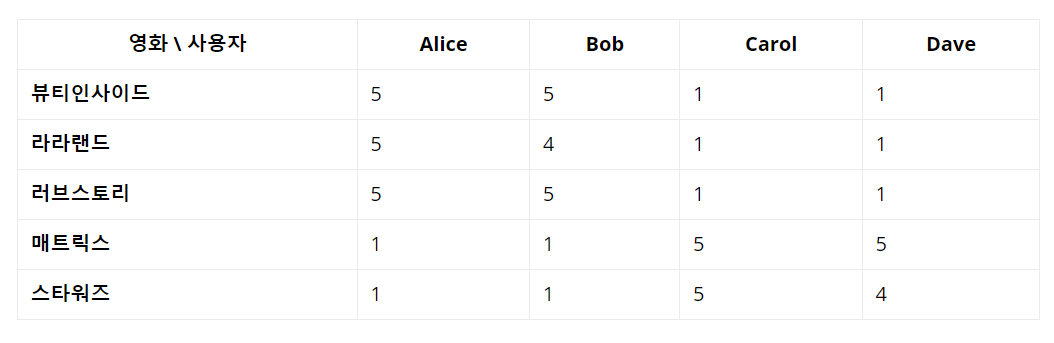

우리는 여기서 앨리스(Alice), 밥(Bob), 캐롤(Carol), 데이브(Dave)를 분류할 수 있는 특징과
뷰티 인사이드, 라라랜드, 러브 스토리, 매트릭스, 스타워즈를 분류 할 수 있는 특징을 발견할 것이다.

영화를 보자
뷰티 인사이드, 라라랜드, 러브 스토리는 ‘로맨틱 영화’로 분류할 수 있고,
매트릭스와 스타워즈는 ‘공상과학 영화’로 분류할 수 있다.

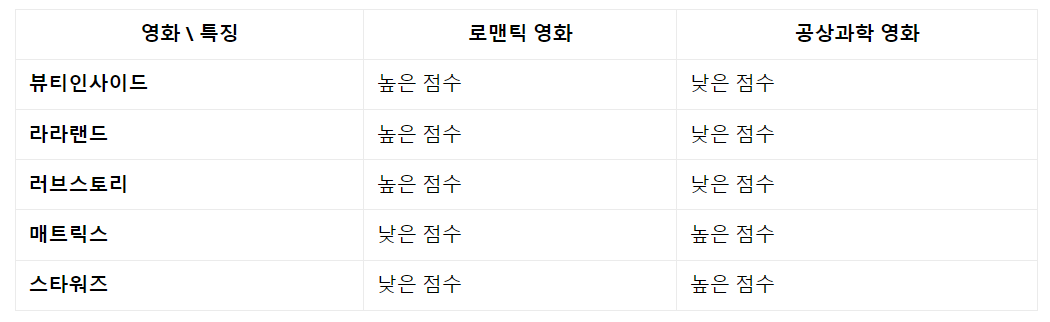

사용자를 보자
앨리스와 밥은 로맨틱 영화를 좋아하고 공상과학 영화를 좋아하지 않는 ‘로맨틱한 사람’으로 분류할 수 있고,
캐롤과 데이브는 공상과학 영화를 좋아하고 로맨틱 영화를 좋아하지 않는 ‘상상력이 풍부한 사람’으로 분류할 수 있다.

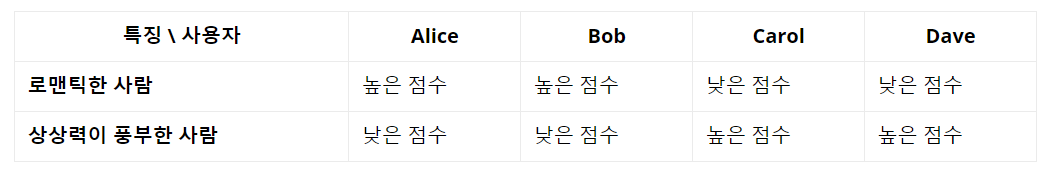

#### 잠재 인수 (Latent factor)
‘로맨틱 영화’, ‘상상력이 풍부한 사람’과 같은 피쳐(feature)는 데이터에서는 보이지 않는다.
이와같이 데이터들 속에 숨어있는 특징을 잠재 인수(Latent factor) 라고 한다.

#### 잠재 인수(Latent factor)의 값들이
영화의 특징을 보여주고
평가자의 특징을 보여 주면서
별점수까지 보여 주는 방법이 없을까?

있다! 그것은 바로…

행렬 인수 분해 (Matrix Factorization)
별점 매트릭스를 𝑅
라고 하자

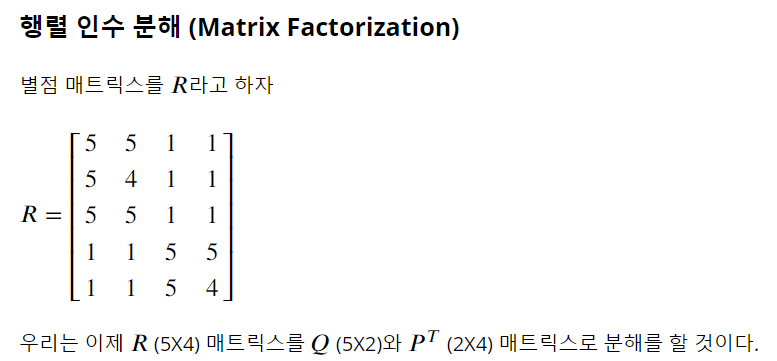

In [51]:
# Non-negative matrix factorization
from sklearn.decomposition import NMF
R = [
     [5,5,1,1],
     [5,4,1,1],
     [5,5,1,1],
     [1,1,5,5],
     [1,1,5,4],
    ]

k = 2 # number of factors
model = NMF(n_components=k)
Q = model.fit_transform(np.array(R))
P = model.components_

아래 𝑄
 매트릭스를 보자.

0번 컬럼(Column)을 ‘로맨틱 영화’,

1번 컬럼(Column)을 ‘공상과학 영화’ 라고 하면

𝑄 매트릭스는 영화의 특징을 나타내고 있다.

In [42]:
# Q (5X2) 매트릭스
pd.DataFrame(Q, columns=['Romantic', 'Sci-Fi'])

,Romantic,Sci-Fi
0,4.604825e-09,1.665017
1,5.505981e-04,1.503893
2,4.604825e-09,1.665017
3,2.823808e-02,0.324661
4,2.545546e-02,0.323760


아래 𝑃𝑇
 매트릭스를 보자.

0번 열(Row)을 ‘로맨틱한 사람’,

1번 열(Row)을 ‘상상력이 풍부한 사람’ 이라고 하면

𝑃𝑇 매트릭스는 사용자의 특징을 나타내고 있다.

In [13]:
# P (2X4) 매트릭스
pd.DataFrame(P, index=['Romantic Guy', 'Imaginary Guy'])

,0,1,2,3
Romantic Guy,0.000000,2.03419,178.499093,160.895328
Imaginary Guy,3.095878,2.90365,0.601347,0.601008


마지막으로 𝑄 와 𝑃𝑇 매트릭스가

별점을 표현하는 지를 확인하기 위해서

𝑄와 𝑃𝑇를 곱해 보자

In [43]:
R_hat = np.dot(Q,P)
pd.DataFrame(R_hat)

,0,1,2,3
0,5.154691,4.834628,1.001254,1.000690
1,4.655869,4.367899,1.002642,0.992441
2,5.154691,4.834628,1.001254,1.000690
3,1.005112,1.000144,5.235706,4.738500
4,1.002321,0.991867,4.738468,4.290246


𝑅
과 비슷한 값이 나온다.

이렇게 𝑅≃𝑄⋅𝑃𝑇
 를 행렬인수분해(Matrix Factorization) 라고 한다.

평가자들의 영화 평점 매트릭스만 가지고

평가자들의 잠재 인수(latent factor)와

영화의 잠재 인수(latent factor)를 추출할 수 있다.


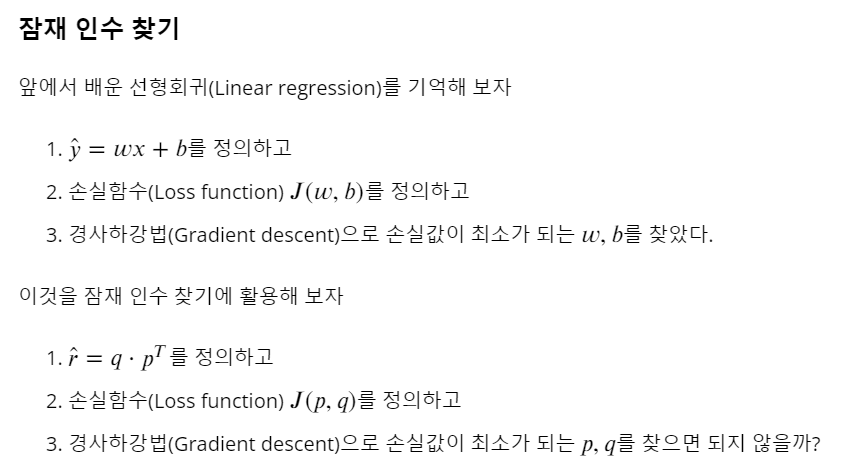

#### Keras를 이용한 미니 모델링

미니 데이터를 가지고 확인 해보자

In [47]:
import pandas as pd
import numpy as np

data = [
    ['Alice', 'Beauty Inside', 5],
    ['Alice', 'La La Land', 5],
    ['Alice', 'Love Story', 5],
    ['Alice', 'Matrix', 1],
    ['Alice', 'Star Wars', 1], 
    ['Bob', 'La La Land', 4],
    ['Bob', 'Love Story', 5],
    ['Bob', 'Matrix', 1],
    ['Bob', 'Star Wars', 1],
    ['Carol', 'Beauty Inside', 1],
    ['Carol', 'La La Land', 1],
    ['Carol', 'Matrix', 5],
    ['Carol', 'Star Wars', 5], 
    ['Dave', 'Beauty Inside', 1], 
    ['Dave', 'La La Land', 1],
    ['Dave', 'Love Story', 1],
    ['Dave', 'Matrix', 5],
    ['Dave', 'Star Wars', 4],
]

mini_df = pd.DataFrame( data = data, columns = ['user', 'item', 'rating'])
mini_df

,user,item,rating
0,Alice,Beauty Inside,5
1,Alice,La La Land,5
2,Alice,Love Story,5
3,Alice,Matrix,1
4,Alice,Star Wars,1
5,Bob,La La Land,4
6,Bob,Love Story,5
7,Bob,Matrix,1
8,Bob,Star Wars,1
9,Carol,Beauty Inside,1


#### 영화 제목을 열(Row)로 하고 사용자 이름을 컬럼(Column)으로 테이블을 만들자

In [48]:
df_table = pd.pivot_table(mini_df, values='rating', index='item', columns='user', fill_value='')
df_table

user,Alice,Bob,Carol,Dave
item,,,,
Beauty Inside,5.0,,1.0,1.0
La La Land,5.0,4.0,1.0,1.0
Love Story,5.0,5.0,,1.0
Matrix,1.0,1.0,5.0,5.0
Star Wars,1.0,1.0,5.0,4.0


#### 데이터 변환 (Data Transformation)
사용자 이름과 영화 제목은 Keras가 입력을 받을 수 있도록 숫자로 변환이 되어야 한다.

사용자(user)를 숫자로 변환해 보자

Alice가 0번, Bob이 1번, Carol이 2번, Dave가 3번으로 변환 되었다.

In [49]:
mini_df.user = mini_df.user.astype('category').cat.codes.values
mini_df

,user,item,rating
0,0,Beauty Inside,5
1,0,La La Land,5
2,0,Love Story,5
3,0,Matrix,1
4,0,Star Wars,1
5,1,La La Land,4
6,1,Love Story,5
7,1,Matrix,1
8,1,Star Wars,1
9,2,Beauty Inside,1


#### 영화 제목(item)을 숫자로 변환한다.
뷰티인사이드가 0, 라라랜드가 1, 러브스토리가 2, 매트릭스가 3, 스타워즈 4로 변환된 것을 확인 할 수 있다.

In [18]:
mini_df.item = mini_df.item.astype('category').cat.codes.values
mini_df

,user,item,rating
0,0,0,5
1,0,1,5
2,0,2,5
3,0,3,1
4,0,4,1
5,1,1,4
6,1,2,5
7,1,3,1
8,1,4,1
9,2,0,1


In [50]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras import regularizers

item_input = Input(shape=[1]) # mini_df.item
user_input = Input(shape=[1]) # mini_df.user

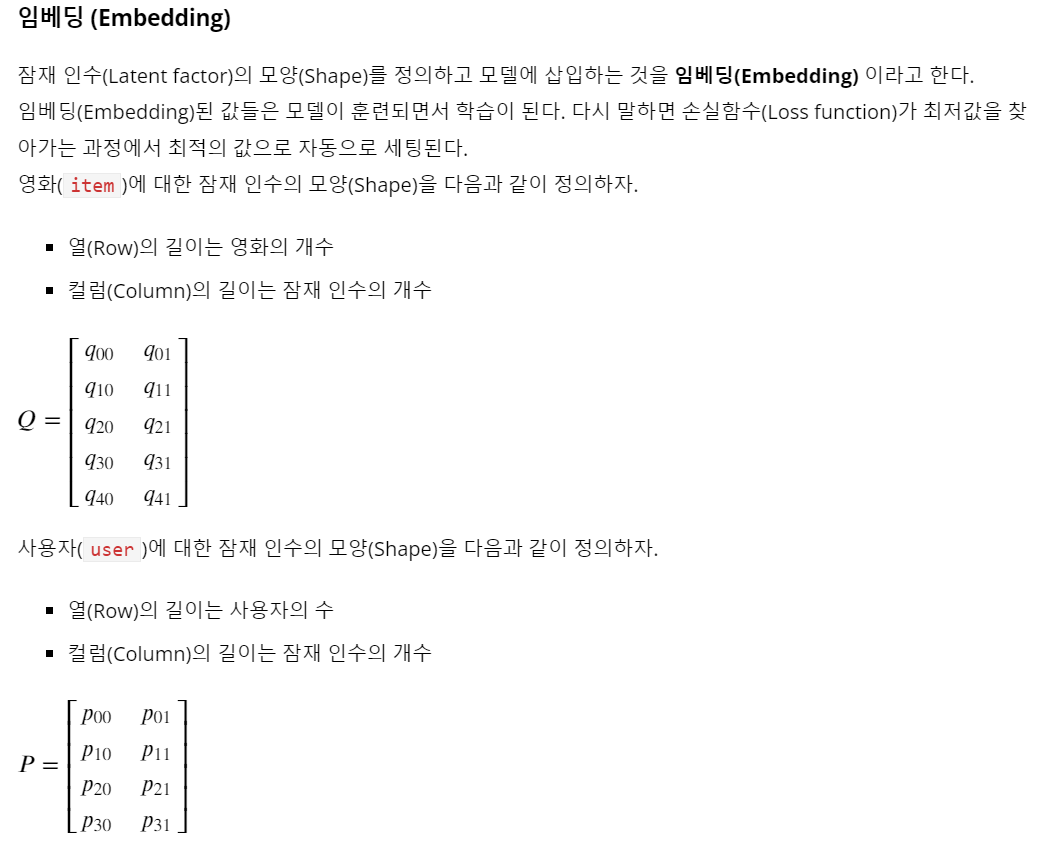

In [21]:
n_items = len(mini_df.item.unique()) # 영화 5편
n_items_latent_factors = 2 # 영화의 잠재 인수 개수

n_users = len(mini_df.user.unique()) # 사용자 4명 
n_users_latent_factors = 2 # 사용자의 잠재 인수 개수

# Item latent factor
item_embedding = Embedding(n_items, n_items_latent_factors, # (5X2) Latent factor
                           embeddings_regularizer=regularizers.l2(0.001),
                           name='item_embedding')(item_input)
# User latent factor
user_embedding = Embedding(n_users, n_users_latent_factors, # (4X2) Latent factor
                           embeddings_regularizer=regularizers.l2(0.001),
                           name='user_embedding')(user_input)

#### 벡터화 (Flattern)
2D로 되어 있는 임베딩(Embedding)을 1D로 변환한다. 이것을 잠재 벡터(Latent vector) 라고 한다.

In [22]:
# Item latent vector
item_vec = Flatten()(item_embedding)
# User latent vector
user_vec = Flatten()(user_embedding)

#### 미니 모델링 (Modeling)
𝑅̂ =𝑄⋅𝑃𝑇

손실 함수(Loss function)는 평균 제곱 오차(mean-squared error)를 사용한다.

최적화(Optimizer)는 경사하강법(gradient descent)을 사용한다.

In [23]:
r_hat = dot([item_vec, user_vec], axes=-1)
mini_model = Model([user_input, item_input], r_hat)
mini_model.compile(optimizer = 'sgd', loss = 'mean_squared_error')

#### 미니 모델 훈련 (Train Model)

loss:  0.07310321182012558


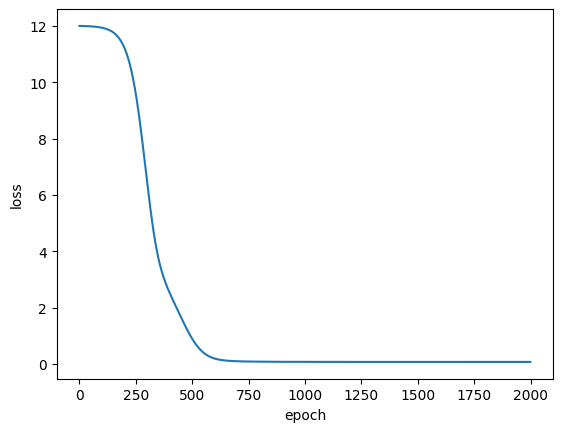

In [24]:
hist = mini_model.fit([mini_df.user, mini_df.item], mini_df.rating, epochs=2000, verbose=0) 
print('loss: ', hist.history['loss'][-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 미니 예측 (Predict)
이제 빵꾸난 별점을 예측해 보자

In [25]:
Q = mini_model.get_layer(name='item_embedding').get_weights()[0]
P = mini_model.get_layer(name='user_embedding').get_weights()[0]
P_t = np.transpose(P)

R_hat = np.dot(Q, P_t)
pd.DataFrame(R_hat)

,0,1,2,3
0,4.986052,4.506554,1.003984,0.994318
1,4.734903,4.280508,1.003063,0.989004
2,5.230497,4.726758,1.014856,1.008485
3,1.002841,1.002525,5.225547,4.729849
4,1.002044,0.992311,4.729233,4.282302


In [27]:
print('뷰티 인사이드에 대한 Bob의 예상 별점은 {:.1f}'.format(R_hat[0][1]))
print('러브 스토리에 대한 Carol의 예상 별점은 {:.1f} 이다.'.format(R_hat[2][2]))

뷰티 인사이드에 대한 Bob의 예상 별점은 4.5
러브 스토리에 대한 Carol의 예상 별점은 1.0 이다.


실제 값과 가깝게 예측을 하고 있다!

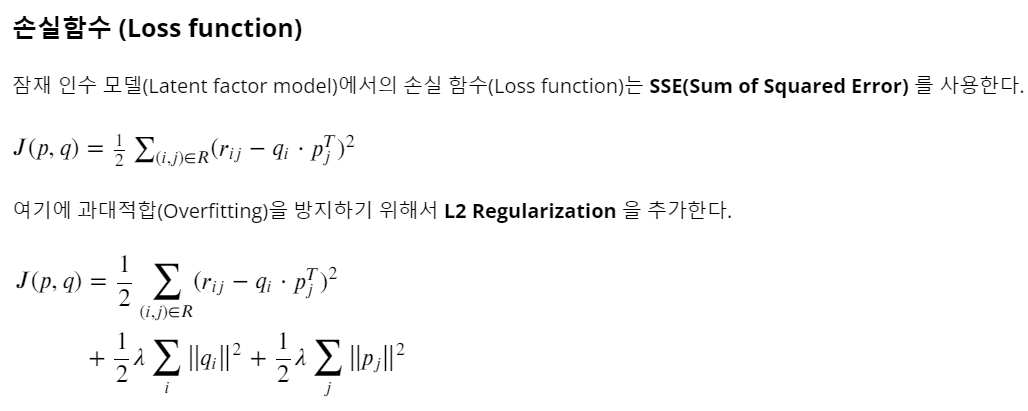

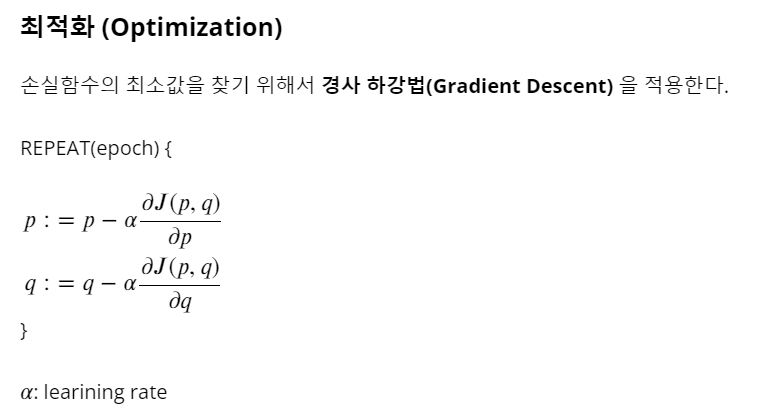

여기서는

SSE 대신에 MSE를

GD 대신에 Adam을 사용한다.

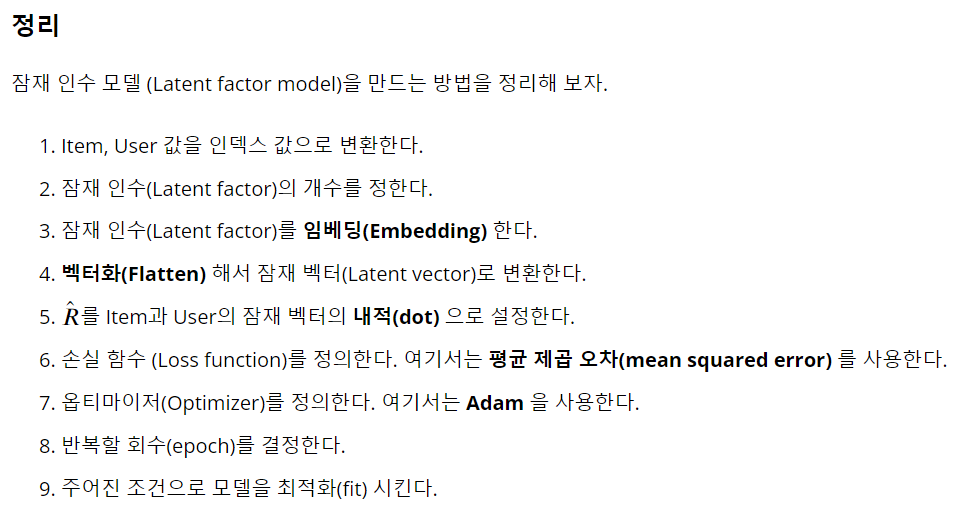

#### 케라스(Keras)로 모델링(Modeling)
데이터 변환
userId와 movieId를 숫자로 변환(인코딩)한다.

In [28]:
# Indexing userId and movieId
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings_df['userId'] = ratings_df['userId'].apply(lambda x: userid2idx[x])
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x: movieid2idx[x])

#### 훈련, 테스트 데이터 분할
훈련 데이터는 ratings_df에서 랜덤하게 80%를 선택하고,

테스트 데이터는 나머지 20%를 랜덤하게 선택한다.

In [29]:
# Split train and test data
split = np.random.rand(len(ratings_df)) < 0.8

train_df = ratings_df[split]
test_df = ratings_df[~split]

print('shape of train data is ',train_df.shape)
print('shape of test data is ',test_df.shape)

shape of train data is  (80541, 4)
shape of test data is  (20295, 4)


#### 임베딩 (Embedding)
잠재 인수 개수를 64개로 하자.

In [31]:
n_movies = len(ratings_df.movieId.unique())
n_users = len(ratings_df.userId.unique())
n_latent_factors = 64

movie_input = Input(shape=[1])
# Item latent factor
movie_embedding = Embedding(n_movies, n_latent_factors,
                            embeddings_regularizer=regularizers.l2(0.00001), 
                            name='movie_embedding')(movie_input)

user_input = Input(shape=[1])
# User latent factor
user_embedding = Embedding(n_users, n_latent_factors,
                           embeddings_regularizer=regularizers.l2(0.00001),
                           name='user_embedding')(user_input)

#### 벡터화 (Flatten)

In [32]:
# Item latent vector
movie_vec = Flatten()(movie_embedding)
# User latent vector
user_vec = Flatten()(user_embedding)

#### 모델링 (Modeling)

In [33]:
r_hat = dot([movie_vec, user_vec], axes=-1)
model = Model([user_input, movie_input], r_hat)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### 모델 훈련 (Train Model)

train loss:  0.22885510325431824


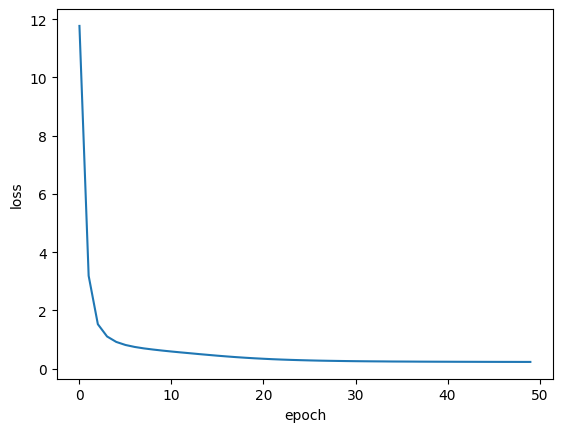

In [34]:
hist = model.fit([train_df.userId, train_df.movieId], train_df.rating, 
                 batch_size=128, epochs=50, verbose=0 ) 

print('train loss: ', hist.history['loss'][-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 모델 평가 (Test Model)

In [35]:
test_loss = model.evaluate([test_df.userId, test_df.movieId], test_df.rating)

print('test loss: ', test_loss)

635/635 [==============================] - 3s 5ms/step - loss: 1.7867
test loss:  1.7867074012756348


#### userId, movieId 값을 입력하시면
예상되는 별점값이 출력 됩니다.

In [36]:
userId = 214       # 1 ~ 610
movieId = 1059  # 1 ~ 193609
movie_title = list(movies_df[movies_df['movieId']==movieId].title)[0]

user_v = np.expand_dims(userid2idx[userId], 0)
movie_v = np.expand_dims(movieid2idx[movieId], 0)
predict = model.predict([user_v, movie_v])

print('영화 {} 에 대한 사용자 ID {}님의 예상 별점은 {:.1f} 입니다.'.format(movie_title, userId, predict[0][0]))

1/1 [==============================] - 0s 211ms/step
영화 William Shakespeare's Romeo + Juliet (1996) 에 대한 사용자 ID 214님의 예상 별점은 3.7 입니다.
